In [165]:
import pandas as pd
from pathlib import Path
import numpy as np
from matplotlib.patches import Wedge
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 14
})


# Extract SEF headers to Excel

In [96]:
root = Path("/scratch3/PALAEO-RA/daily_data/final/")
rows = []

files = list(root.rglob("*.tsv")) # gets all tsv files recursively

for path in files:
    
    # ------------ read metadata until "Year" ------------
    meta = {}
    
    # read whole file
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            # stop at start of the actual SEF table
            if line.startswith("Year"):
                break
            if "\t" in line:
                key, val = line.split("\t", 1)
                meta[key] = val
    
    # ------------ detect table header row ------------
    with path.open("r", encoding="utf-8") as f:
        table_start = None
        for i, line in enumerate(f):
            if line.startswith("Year"):
                table_start = i
                break

    # ------------ read the table safely ------------
    df_file = pd.read_csv(
        path,
        sep="\t",
        header=table_start,
        dtype=str,
        on_bad_lines="skip"
    )

    # ------------ compute start/end date ------------
    meta["filename"]   = path.name
    meta["start_date"] = df_file["Year"].iloc[0] + "-" + df_file["Month"].iloc[0] + "-" + df_file["Day"].iloc[0]
    meta["end_date"]   = df_file["Year"].iloc[-1] + "-" + df_file["Month"].iloc[-1] + "-" + df_file["Day"].iloc[-1]

    rows.append(meta)


In [97]:
df = pd.DataFrame(rows)
df["Vbl"] = df["Vbl"].astype(str).str.strip() # remove trailing whitespace and annoying "\t"
df.to_csv("/scratch3/PALAEO-RA/daily_data/final/metadata_summary.csv", index=False)

# Make Station Map

In [130]:
df = pd.read_csv("/scratch3/PALAEO-RA/daily_data/final/metadata_summary.csv")

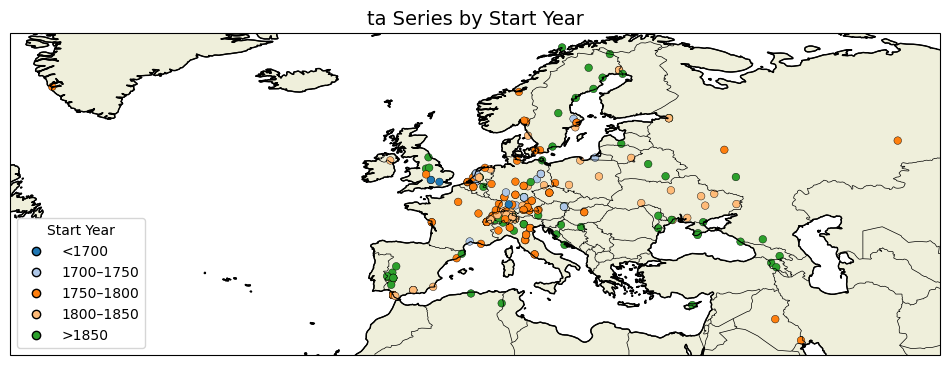

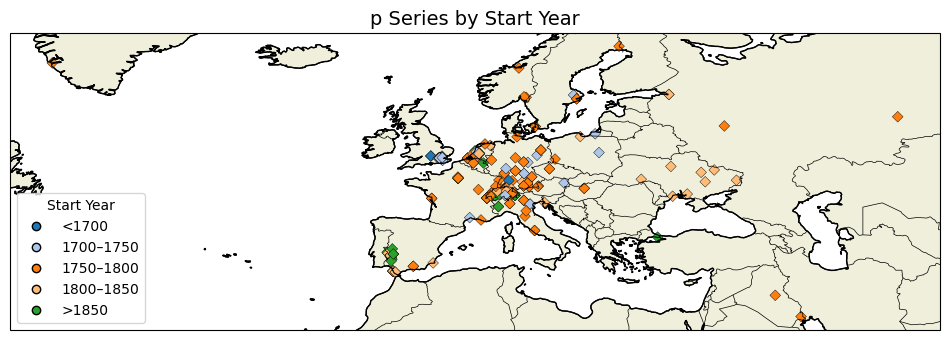

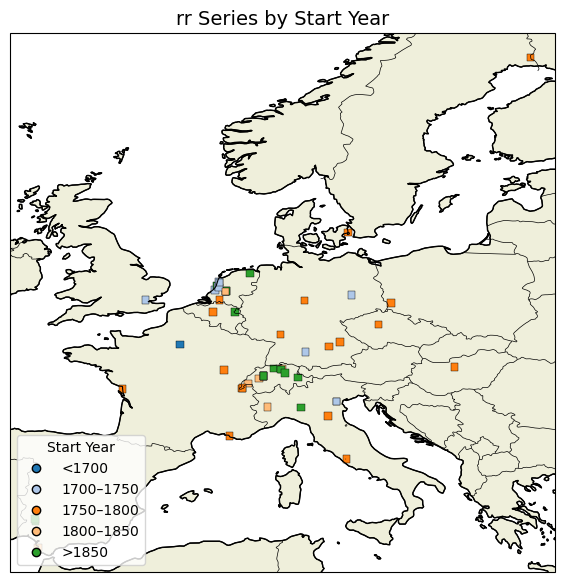

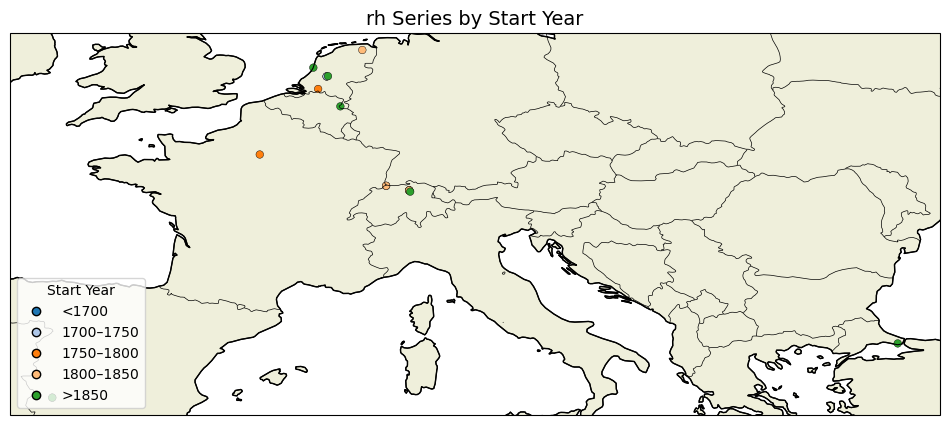

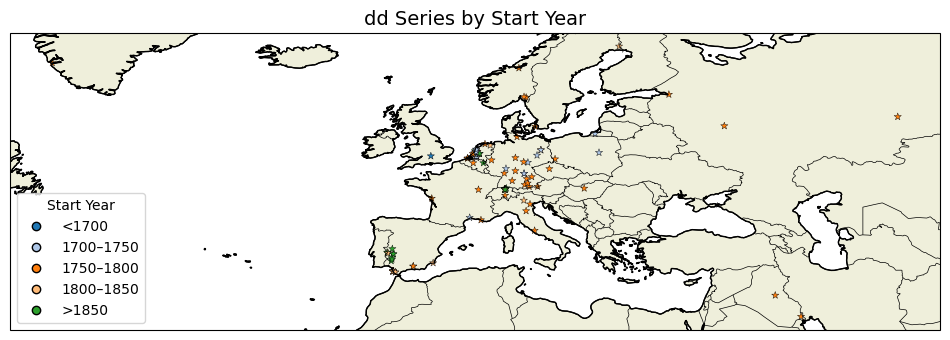

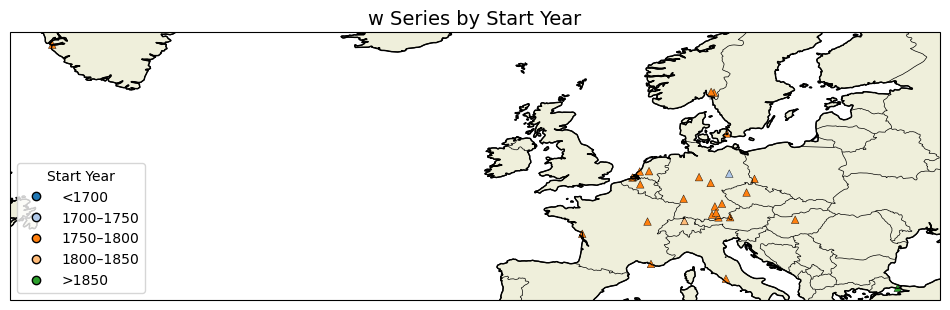

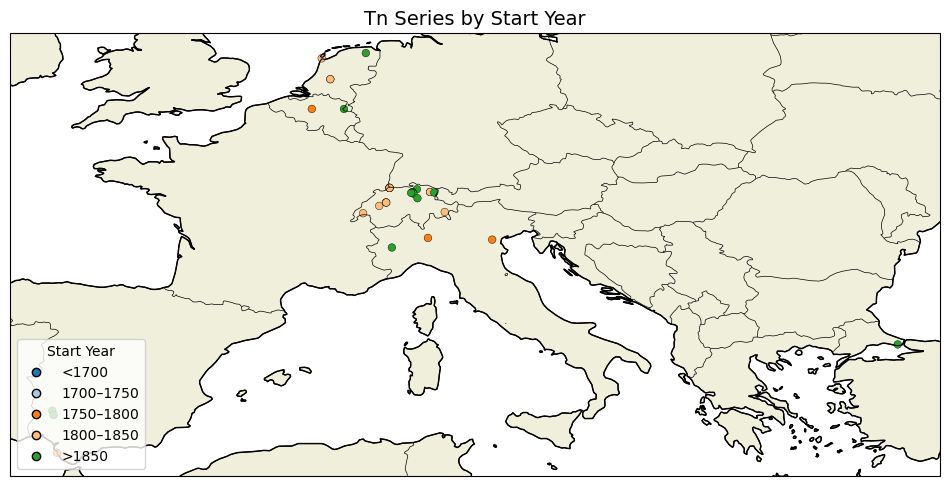

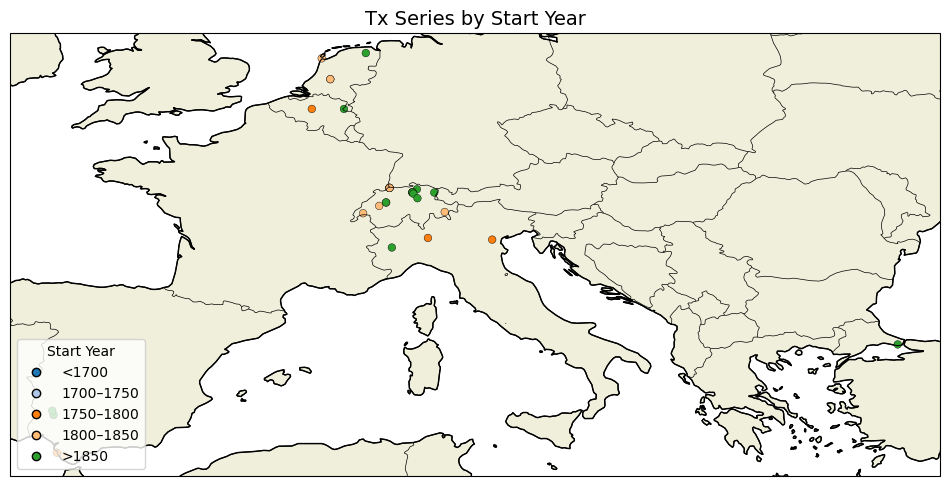

In [ ]:
start_year = df['start_date'].str.split("-").str[0].astype(int)
end_year   = df['end_date'].str.split("-").str[0].astype(int)

# define bins for colors
bins   = [-9999, 1700, 1750, 1800, 1850, 1900]
labels = ["<1700", "1700–1750", "1750–1800", "1800–1850", ">1850"]

df["start_period"] = pd.cut(start_year, bins=bins, labels=labels)
df['start_code']   = df['start_period'].cat.codes


################################################################

# numeric codes for color values
codes = df["start_period"].cat.codes
cats  = df["start_period"].cat.categories
cmap  = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(len(cats))] # pick 5 colors within tab20

# marker mapping
var_markers = {
    "ta": "o",
    "p":  "D",
    "rr": "s",
    "dd": "*",
    "w":  "^",
}

valid_vars = ["ta", "p", "rr", "rh", "dd", "w", "Tn", "Tx"]

# one map per variable
for var in valid_vars:
    df_var = df[df["Vbl"] == var].copy()

    marker = var_markers.get(var, "X")
    df_var_codes = df_var["start_period"].cat.codes
    point_colors = [colors[code] for code in df_var_codes]

    plt.figure(figsize=(12, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_extent([-12, 40, 33, 73], crs=ccrs.PlateCarree())

    # Add contours
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black')

    # plot all points at once and color by period
    plt.scatter(
        df_var["Lon"].astype(float),
        df_var["Lat"].astype(float),
        color=point_colors,
        s=30,
        edgecolor="black",
        linewidth=0.3,
        marker=var_markers.get(var, "o"),
        transform=ccrs.PlateCarree(),
        label=var
    )

    # ----- custom legend -----
    legend_elements = [
        Line2D(
            [0], [0],
            marker="o",
            color="white",
            label=str(cat),
            markerfacecolor=colors[i],
            markeredgecolor="black",
            markersize=6,
            linewidth=0.2
        )
        for i, cat in enumerate(cats)
    ]

    # legend
    plt.legend(handles=legend_elements, title="Start Year", loc="lower left")
    plt.title(f"{var} Series by Start Year", fontsize=14)
    plt.savefig(f"/scratch2/ccorbella/code/dataprep/image/station_map_start_year_{var}.png", dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

# Make a Pie Chart

In [105]:
var_counts = df["Vbl"].value_counts()
total_counts = var_counts.sum()
var_counts

Vbl
ta     345
p      284
dd     100
rr      53
Tn      38
Tx      34
w       28
rh      18
eee      8
rrt      6
tb       4
fs       1
Name: count, dtype: int64

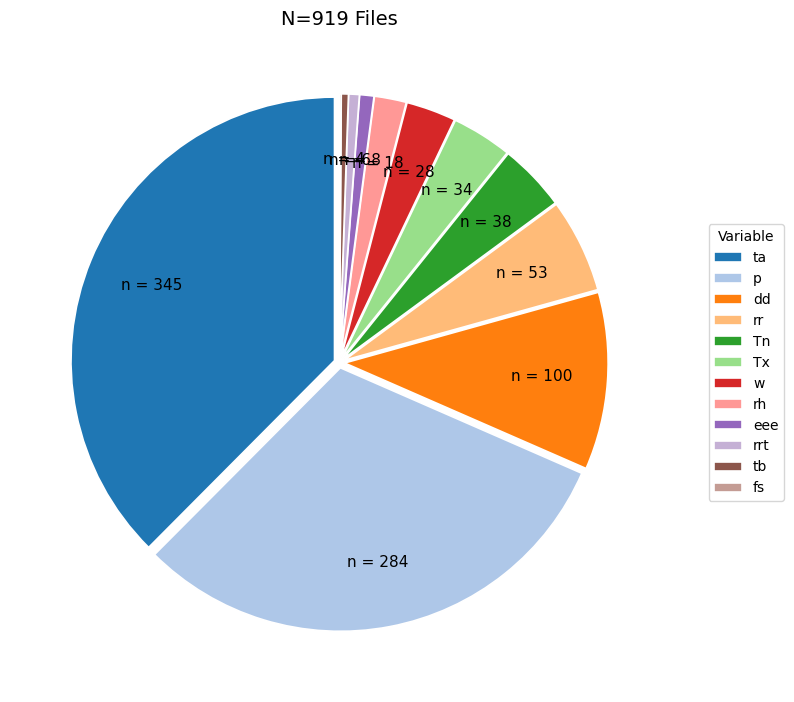

In [112]:
def count_label(pct):
    '''write number of counts instead of percentage and hide for tiny slices'''
    count = int(round(pct/100 * total_counts))
    if count <= 2:
        return ""         # hide labels for tiny slices
    return f"n = {count}"

labels = var_counts.index

# explode a tiny amount for all slices for aesthetics
plt.figure(figsize=(8, 8))

patches, texts, autotexts = plt.pie(
    var_counts.values,
    labels=None,               # we'll add custom legend
    explode=[0.02] * len(var_counts),
    autopct=count_label,
    startangle=90,
    pctdistance=0.75,
    colors=plt.get_cmap("tab20").colors,
    wedgeprops=dict(edgecolor="white", linewidth=1.2)
)

# format inside-text
for at in autotexts:
    at.set_color("black")
    at.set_fontsize(11)

plt.title(f"N={total_counts} Files", fontsize=14)

# custom legend (so labels don't clutter the pie)
plt.legend(
    patches,
    labels,
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    title="Variable"
)

plt.tight_layout()
plt.savefig("/scratch2/ccorbella/code/dataprep/image/pie_chart.png", dpi=300, bbox_inches="tight")
plt.show()

# Make Timeseries of Num Vars

In [136]:
# we can't use datetime directly because of invalid dates before 1677
df["start_year"] = df["start_date"].astype(str).str.split("-").str[0].astype(int)
df["end_year"]   = df["end_date"].astype(str).str.split("-").str[0].astype(int)

min_year = df["start_year"].min()
max_year = df["end_year"].max()

years = pd.Index(range(int(min_year), max_year + 1))

coverage = pd.DataFrame(index=years, columns=valid_vars).fillna(0)

for var in valid_vars:
    dfv = df[df["Vbl"] == var]

    for _, row in dfv.iterrows():
        coverage.loc[row["start_year"]:row["end_year"], var] += 1

/tmp/ipykernel_3019769/3210244124.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  coverage = pd.DataFrame(index=years, columns=valid_vars).fillna(0)


In [154]:
ax.get_ylim()[1] * 0.95

66.8325

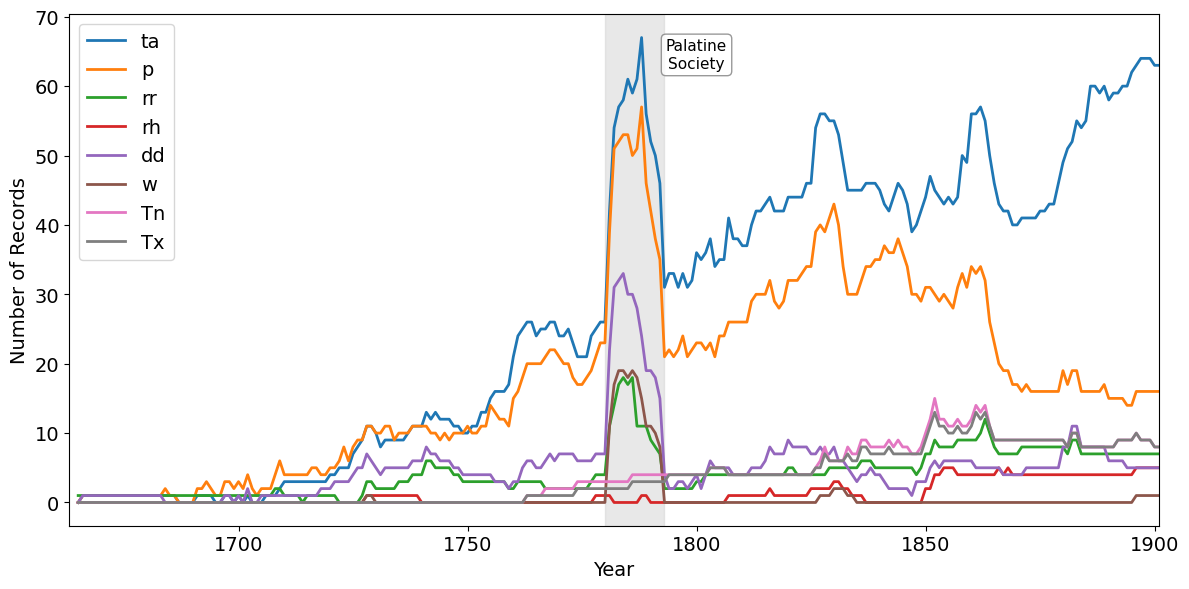

In [167]:
plt.figure(figsize=(12, 6))
ax = plt.gca()

# highlight Palatine Society period
ax.axvspan(1780, 1793, color="lightgray", alpha=0.5, zorder=0)


for var in valid_vars:
    plt.plot(
        coverage.index,
        coverage[var],
        label=var,
        linewidth=2
    )

ax.text(
    x=1800,
    y=ax.get_ylim()[1] * 0.95,  # near the top of the plot
    s="Palatine\nSociety",      # newline
    ha="center",
    va="top",
    fontsize=11,
    bbox=dict(
        facecolor="white",
        edgecolor="gray",
        alpha=0.8,
        boxstyle="round,pad=0.3"
    )
)

plt.xlabel("Year")
plt.xlim(min_year-2,1901)
ax.set_xticks([1700, 1750, 1800, 1850, 1900])

plt.ylabel("Number of Records")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("/scratch2/ccorbella/code/dataprep/image/temporal_coverage_timeseries.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()